In [1]:
import sys
import os
sys.path.append('../../')

import glob
import tqdm

import matplotlib.pyplot as plt
import numpy as np
import cv2

import rasterio
import rasterio.plot

import pydensecrf.densecrf as dcrf

from utils.draw import colorize_dynamic_world_label
from utils.postprocessing import dense_crf

In [2]:
# BASE_DIR = '/data/microsoft_planetary_computer/outputs/preprocessed/'
BASE_DIR = '/data/chesapeake_bay_lulc/outputs/preprocessed'
EPSG = 'epsg-32618'
DATASET = 'clinton'
RESOLUTION = '1.0'

dynamicworld_label_path = os.path.join(BASE_DIR, EPSG, DATASET, 'dynamicworld', RESOLUTION, 'mosaic.tiff')
naip_path = os.path.join(BASE_DIR, EPSG, DATASET, 'naip', RESOLUTION, 'mosaic.tiff')
# planet_path = os.path.join(BASE_DIR, EPSG, DATASET, 'planet', RESOLUTION, 'mosaic.tiff')
dem_1m_path = os.path.join(BASE_DIR, EPSG, DATASET, 'dem_1m', RESOLUTION, 'mosaic.tiff')
dem_path = os.path.join(BASE_DIR, EPSG, DATASET, 'dem', RESOLUTION, 'mosaic.tiff')
dsm_path = os.path.join(BASE_DIR, EPSG, DATASET, 'dsm', RESOLUTION, 'mosaic.tiff')

In [3]:
dynamicworld_label = rasterio.open(dynamicworld_label_path)
naip = rasterio.open(naip_path)
# planet = rasterio.open(planet_path)

In [4]:
naip_data = naip.read()
# planet_data = planet.read()
dynamicworld_label_data = dynamicworld_label.read()


In [5]:
naip_data.shape

(4, 4911, 7781)

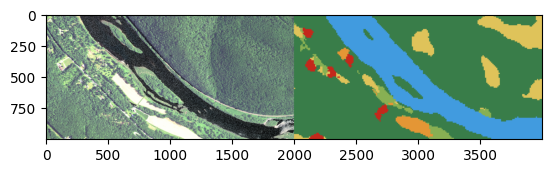

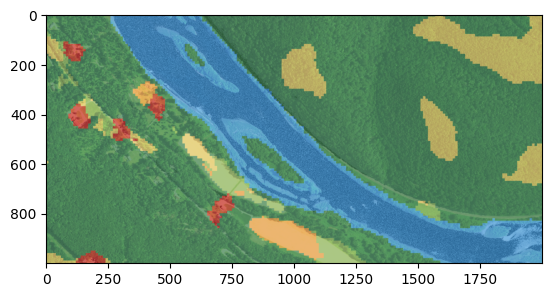

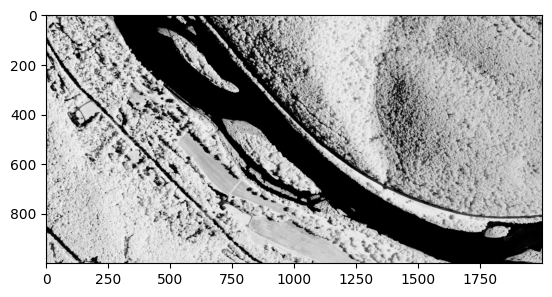

In [11]:
x1, x2 = 2000, 4000
y1, y2 = 3000, 4000


naip_patch = naip_data[:3, y1:y2, x1:x2].transpose(1, 2, 0)
# planet_patch = planet_data[:3, y1:y2, x1:x2].transpose(1, 2, 0)
dynamicworld_label_patch = dynamicworld_label_data[:, y1:y2, x1:x2].transpose(1, 2, 0)
dynamicworld_label_patch[:,:,-1] = np.argmax(dynamicworld_label_patch[:,:,:-1], axis=2)
dynamicworld_colorized_label_patch = colorize_dynamic_world_label(dynamicworld_label_patch[:,:,-1])

sxs = np.hstack([naip_patch, dynamicworld_colorized_label_patch])
overlay = cv2.addWeighted(naip_patch, 0.3, dynamicworld_colorized_label_patch, 0.7, 0)

plt.imshow(sxs)
plt.show()
plt.imshow(overlay)
plt.show()
plt.imshow(naip_data[3, y1:y2, x1:x2], cmap='gray')
plt.show()

In [12]:
np.unique(dynamicworld_label_patch[:,:,-1])

array([0., 1., 2., 4., 5., 6.], dtype=float32)

In [17]:
prob = np.ascontiguousarray(dynamicworld_label_patch[:,:,:-1])
img = np.ascontiguousarray(naip_patch)
# img = np.ascontiguousarray(planet_patch)

params = dict(
    sxy=3, 
    srgb=15, 
    compat=10, 
    kernel=dcrf.DIAG_KERNEL, 
    normalization=dcrf.NORMALIZE_SYMMETRIC,
    inference_steps=5,
)
map_estimate = dense_crf(prob, img, **params)

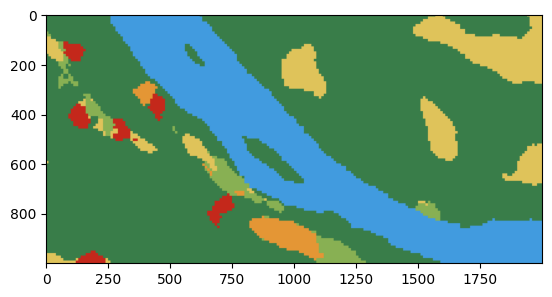

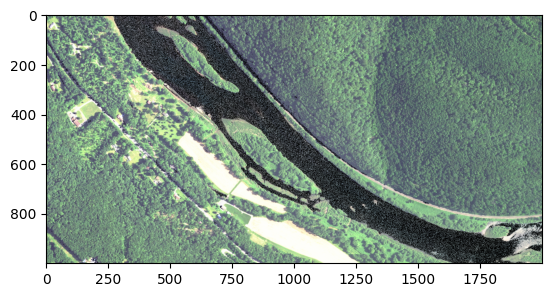

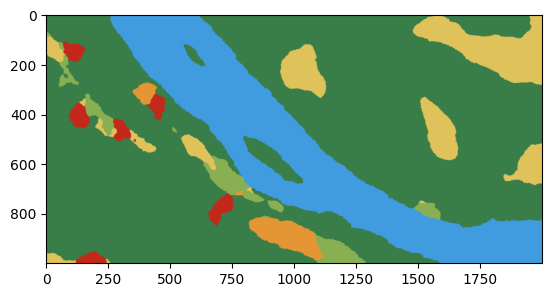

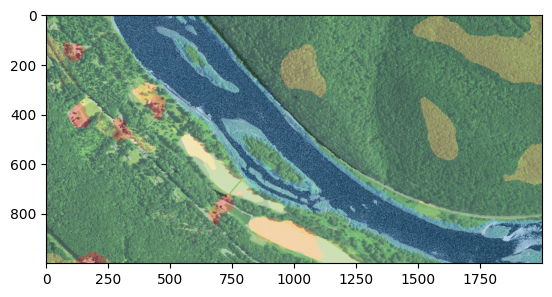

In [18]:
plt.imshow(dynamicworld_colorized_label_patch)
plt.show()

# plt.imshow(planet_patch[5000:7000, 6000:8000, :])
# plt.show()
plt.imshow(naip_patch)
plt.show()


color_estimate = colorize_dynamic_world_label(map_estimate)
plt.imshow(color_estimate)
plt.show()

overlay = cv2.addWeighted(naip_patch, 0.6, color_estimate, 0.4, 0)
plt.imshow(overlay)
plt.show()

In [11]:
x = rasterio.open('/data/microsoft_planetary_computer/planet/castaic_lake/4band/composite_file_format.tif')

In [26]:
y = x.read().transpose(1, 2, 0)

In [60]:
y_infrared = cv2.convertScaleAbs(y[:,:,3], alpha=(255.0/(2**16)))
y_rgb = cv2.normalize(y[:,:,0:3], None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

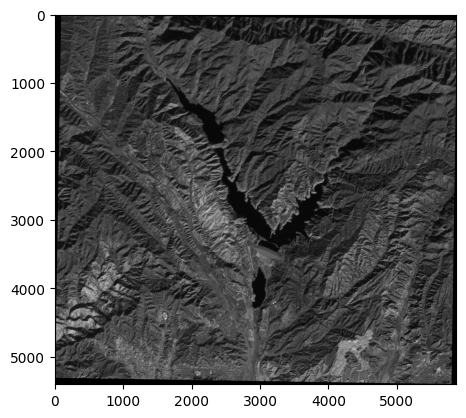

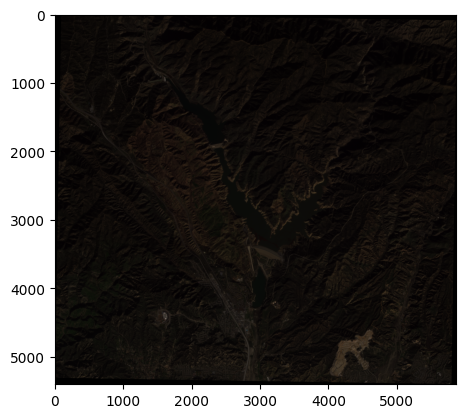

In [62]:
plt.imshow(y_infrared, cmap='gray')
plt.show()
plt.imshow(cv2.cvtColor(y_rgb, cv2.COLOR_BGR2RGB))
plt.show()

In [51]:
y[:,:,0:3].max()

13852

In [25]:
cl = rasterio.open('/data/chesapeake_bay_lulc/outputs/preprocessed/epsg-32618/clinton/chesapeake_bay_lc/1.0/mosaic.tiff')
cl_data = cl.read()

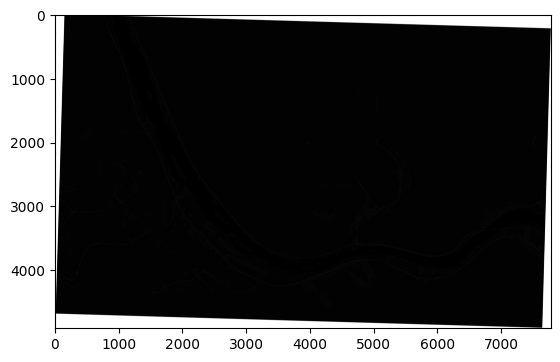

<Axes: >

In [31]:
rasterio.plot.show(cl_data, cmap='gray')

In [32]:
np.unique(cl_data)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12, 255],
      dtype=uint8)

In [36]:
np.unique(dynamicworld_label_data[-1])

array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32)